<center> 
<h2><b> Adnan Rashid </b></h2>
    <nav>
        <h3>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
        <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
        <a href="https://adnan.study"> Website </a> |
        <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
        <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
        </h3>
    </nav>
</center>

<h1 style="background:black"><code style="background:black;color:white"><center>Introduction to RBAC</center></code></h1>

<div class="alert alert-block alert-warning"><font style="color:black"><center> In this section we will learn about how role based access control (RBAC) works in kubernetes. <br><br>We will explore Kubernetes RBAC by creating an IAM user called 'rbac-user' who is authenticated to access the EKS cluster but is only authorized (via RBAC) to list, get and watch pods and deployments in the 'rbac-test' namespace.<br><br>To achieve this, we'll create IAM user, map that user to a kubernetes role, then perform kubernetes actions under that user's context.</center></font></div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/15.jpg" width="50%" height="50%" border=5/></center>

* [What is RBAC?](#whatrbac)
* [Install Test Pods](#testpods)
* [Create a User](#createuser)
* [Map an IAM User to K8s](#mapiam)
* [Test the new user](#testuser)
* [Create the Role and Binding](#createrole)
* [Verify the Role and Binding](#verifyuser)
* [Cleanup](#rbaccleanup)

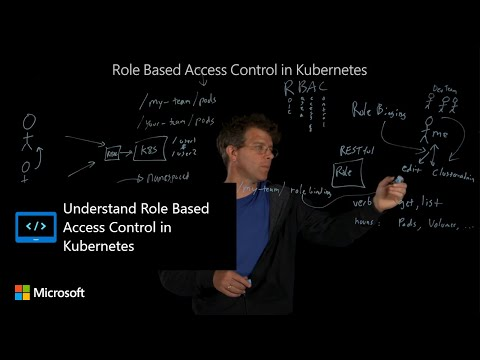

In [29]:
from IPython.display import YouTubeVideo
YouTubeVideo('G3R24JSlGjY')

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

## What is RBAC? <a class="anchor" id="whatrbac"></a>

<blockquote> Role Based Access Control (RBAC) is a method of regulating access to computer or network resources based on the roles of individual users within an enterprise

* <b> Entity </b> 
    * A group, user or service account 
    * An identity representing an application that wants to execute certain operations (actions) and requires permissions to do so 
    
* <b> Resource </b> 
    * A pod, service or secret that the entity wants to access using a certain operation
    
* <b> Role </b> 
    * Used to define rules for the actions the entity can take on various resources 
    
* <b> Role Binding </b> 
    * This attaches (binds) a role to an entity, stating that the set of rules define the actions permitted by the attached entity on the specified resources. 
    * There are two types of Roles (Role, ClusterRole) and the respective bindings (RoleBinding, ClusterRoleBinding). These differentiate between authorization in a namespaceor cluster-wide 
    
* <b> Namespace </b> 
    * Namespaces are an excellent way of creating security boundaries, they also provide a unique scope for object names as the 'namespace' name implies. 
    * They are intended to be used in multi-tenant environments to create virtual kubernetes clusters on the same phystical cluster. 

## <br><br>Install the Test Pods <a class="anchor" id="testpods"></a>

We are going to demonstrate how to provide limited access to pods running in the rbac-test namespace for user named rbac-user 

* First lets create the rbac-test namespace, and then install nginx into it

In [ ]:
!kubectl create namespace rbac-test 
!kubectl create deploy nginx --image=nginx -n rbac-test 

* Verify the test pods were propertly installed 

In [ ]:
!kubectl get all -n rbac-test

## <br><br>Create a User <a class="anchor" id="createuser"></a>

<div class="alert alert-block alert-danger">
<font style="color:black"><center>

<ol>Note: For the sake of simplicity we will save credentials to environment variable to make it easy to toggle back and forth between users. </ol>
<ol>NEVER do this in production or even development and especially not with credentials that have privledged access </ol>
<ol>Remember to clear all outputs and destroy the keys at the end. Git-secrets, if installed, will also block any commits to github </ol>
    </center></font></div>

* Create a new user called 'rbac-user' and generate credentials

In [ ]:
!aws iam create-user --user-name rbac-user 

In [ ]:
!aws iam create-access-key --user-name rbac-user  

## <br><br> Map an IAM User to Kubernetes <a class="anchor" id="mapiam"></a>

We will define a kubernetes user called rbac-user, and map to its IAM user counterpart. 

* The following will get the existing ConfigMap and save into a file called aws-auth.yaml 

In [ ]:
!kubectl get configmap -n kube-system aws-auth -o yaml > rbac/aws-auth.yaml 

* Append the rbac-user mapping to the existing configMap

In [ ]:
%%bash

cat << EoF >> rbac/aws-auth.yaml
data:
  mapUsers: |
    - userarn: arn:aws:iam::${ACCOUNT_ID}:user/rbac-user
      username: rbac-user
EoF

<br><br>Some of the values may be dynamically populated when the file is created 

* To verify everything populated and was created correctly run the following

In [ ]:
!cat rbac/aws-auth.yaml

* Apply the ConfigMap to apply this mapping to the system

In [ ]:
!kubectl apply -f rbac/aws-auth.yaml

## <br><br> Test the New User <a class="anchor" id="testuser"></a>

Until now, as the cluster operator, you have been accessing the cluster as the admin user. 

Lets see what happens when we access the newly created rbac-user 

* Using the credentials generated above, set the environment variables

In [ ]:
%env AWS_ACCESS_KEY_ID=<ACCESS_KEY_ID>
%env AWS_SECRET_ACCESS_KEY=<SECRET_ACCESS_ID>

* Check identity

In [ ]:
!aws sts get-caller-identity

* Now that we are making calls in the context of the rbac-user, lets make a request to get all pods

In [ ]:
!kubectl get pods -n rbac-test

<blockquote>We should get an error, but why?<br><br>
Just creating the user does not give that user access to any resources in the cluster.<br><br>
In order to achieve that, we'll need to define a role, and then bind the user to that role<br><br>

## <br><br> Create the Role and Binding <a class="anchor" id="createrole"></a>

We have our new user rbac-user, but its not yet bound to any roles 

* We will need to switch back to default admin user by clearing the environment variables 

Run the below as it is

In [ ]:
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=

* Verify we are the admin user again, and no longer rbac-user

In [ ]:
!aws sts get-caller-identity

<blockquote>
We will apply a role called 'pod-reader' that provides <br><br>
* list, get and watch access for pods and deployments <br><br>
* only for rbac-test namespace 
</blockquote> 

*  We have the user, the role and now we are binding them together with the RoleBinding resource. 

In [ ]:
!kubectl apply -f RBAC/rbacuser-role.yaml 
!kubectl apply -f RBAC/rbacuser-role-binding.yaml

## <br><br> Verify the Role and Binding <a class="anchor" id="verifyrole"></a>

* Now that we have user, Role and RoleBinding defined, we need to switch back to rbac-user and test

In [ ]:
%env AWS_ACCESS_KEY_ID=<ACCESS_KEY_ID>
%env AWS_SECRET_ACCESS_KEY=<SECRET_ACCESS_ID>

* Check identity

In [ ]:
!aws sts get-caller-identity

* Get the pods from the rbac namespace with our rbac-user

In [ ]:
!kubectl get pods -n rbac-test 

* Try running the same command but outside of the rbac-test namespace

In [ ]:
!kubectl get pods -n kube-system 

<br><br>We should get an <b>error</b> and this is because the role you are bound to does not give you access to any namespace other than rbac-test 

## <br><br> Clean Up<a class="anchor" id="rbaccleanup"></a>

* Clear the variables

In [ ]:
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=

* Delete the namespace, access key using the ID and then the user 

In [ ]:
!kubectl delete namespace rbac-test
!aws iam delete-access-key --user-name=rbac-user --access-key-id=<ACCESS_KEY_ID>
!aws iam delete-user --user-name rbac-user 

<br><Br>
<div class="alert alert-block alert-danger">
<font style="color:black">
<center>Important: Go into your AWS account and ensure the user has been removed along with the outputs from above (Edit --> Clear Outputs) 
    </center></font></div>